In [1]:
import sys
sys.path.append("..")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import statsmodels.api as sm
import scipy.signal

from statsmodels.tsa.seasonal import STL
import datetime as dt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import coint, adfuller

In [2]:
from laos_gggi.combine_data import final_data

# Data

In [3]:
data = final_data()

In [4]:
time_series = data["df_time_series"].reset_index().set_index("Date")

In [5]:
#Total events around the world
total_events_world =  (data["emdat_events"].sum(axis = 1).reset_index().rename(columns = {0: "Total_events"})
 .pivot_table(values= "Total_events",  index = "Start_Year", aggfunc= "sum")).iloc[ 2: ,  ].reset_index()

total_events_world["Start_Year"] = pd.to_datetime(total_events_world["Start_Year"], format='%Y')
total_events_world = total_events_world.set_index("Start_Year")


#Total events around the world
total_damages_world = (data["emdat_damage"].sum(axis = 1).reset_index().rename(columns = {0: "Total_damages"})
 .pivot_table(values= "Total_damages",  index = "Start_Year", aggfunc= "sum")).iloc[ 2: ,  ].reset_index()

total_damages_world["Start_Year"] = pd.to_datetime(total_damages_world["Start_Year"], format='%Y')
total_damages_world = total_damages_world.set_index("Start_Year")


#Total number of floods
total_floods_world = ( data["emdat_events"].reset_index()[["Flood", "ISO", "Start_Year"]]
                     .pivot_table(values= "Flood",  index = "Start_Year", aggfunc= "sum").iloc[ 2: ,  ].reset_index())

total_floods_world["Start_Year"] = pd.to_datetime(total_floods_world["Start_Year"], format='%Y')
total_floods_world = total_floods_world.set_index("Start_Year")

# Utilities

In [6]:
#Determine the number of lags fro ACF and PACF
nlags= 36

In [7]:
# Augmented Dickey Fuller function

# First define make_var_names function to obtain the complete results of the ADF test

def make_var_names(var, n_lags, reg):
    names = [f'L1.{var}']
    for lag in range(1, n_lags + 1):
        names.append(f'D{lag}L1.{var}')
    if reg != 'n':
        names.append('Constant')
    if 't' in reg:
        names.append('Trend')

    return names

def ADF_test_summary(df, maxlag=None, autolag='BIC', missing='error'):
    if missing == 'error':
        if df.isna().any().any():
            raise ValueError("df has missing data; handle it or pass missing='drop' to automatically drop it.")
            
    if isinstance(df, pd.Series):
        df = df.to_frame()
        
    for series in df.columns:
        data = df[series].copy()
        if missing == 'drop':
            data.dropna(inplace=True)
            
        print(series.center(110))
        print(('=' * 110))
        line = 'Specification' + ' ' * 15 + 'Coeff' + ' ' * 10 + 'Statistic' + ' ' * 5 + 'P-value' + ' ' * 6 + 'Lags' + ' ' * 6 + '1%'
        line += ' ' * 10 + '5%' + ' ' * 8 + '10%'
        print(line)
        print(('-' * 110))
        spec_fixed = False
        for i, (name, reg) in enumerate(zip(['Constant and Trend', 'Constant Only', 'No Constant'], ['ct', 'c', 'n'])):
            stat, p, crit, regresult = sm.tsa.adfuller(data, regression=reg, regresults=True, maxlag=maxlag,
                                                       autolag=autolag)
            n_lag = regresult.usedlag
            gamma = regresult.resols.params[0]
            names = make_var_names(series, n_lag, reg)
            reg_coefs = pd.Series(regresult.resols.params, index=names)
            reg_tstat = pd.Series(regresult.resols.tvalues, index=names)
            reg_pvals = pd.Series(regresult.resols.pvalues, index=names)

            line = f'{name:<21}{gamma:13.3f}{stat:15.3f}{p:13.3f}{n_lag:11}{crit["1%"]:10.3f}{crit["5%"]:12.3f}{crit["10%"]:11.3f}'
            print(line)

            for coef in reg_coefs.index:
                if coef in name:
                    line = f"\t{coef:<13}{reg_coefs[coef]:13.3f}{reg_tstat[coef]:15.3f}{reg_pvals[coef]:13.3f}"
                    print(line)

# Ocean temperature

## Seasonal-trend decomposition 

In [8]:
stl_ocean_temp = STL(time_series["Temp"])
result_ocean_temp = stl_ocean_temp.fit()

In [9]:
trend_ocean_temp, seasonal_ocean_temp, resid_ocean_temp = result_ocean_temp.trend, result_ocean_temp.seasonal,  result_ocean_temp.resid

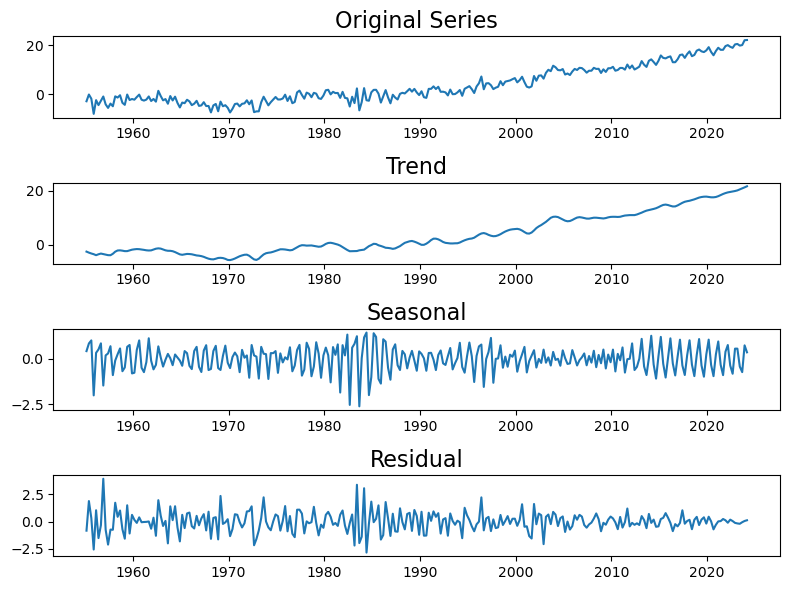

In [10]:
plt.figure(figsize=(8,6))

plt.subplot(4,1,1)
plt.plot(time_series["Temp"])
plt.title('Original Series', fontsize=16)

plt.subplot(4,1,2)
plt.plot(trend_ocean_temp)
plt.title('Trend', fontsize=16)

plt.subplot(4,1,3)
plt.plot(seasonal_ocean_temp)
plt.title('Seasonal', fontsize=16)

plt.subplot(4,1,4)
plt.plot(resid_ocean_temp)
plt.title('Residual', fontsize=16)

plt.tight_layout( )

## Remove trend

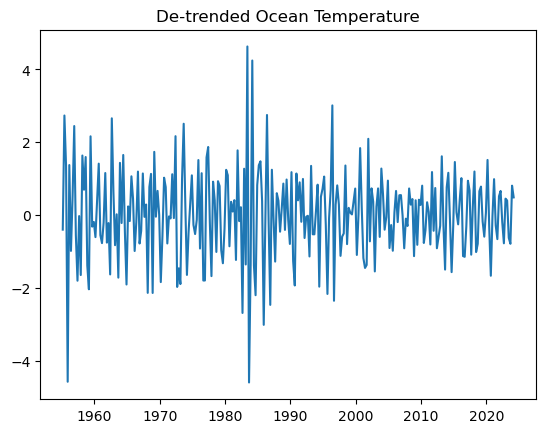

In [11]:
#Obtain de-trended
detrended_ocean_temp = time_series["Temp"] - trend_ocean_temp

plt.plot(detrended_ocean_temp)
plt.title("De-trended Ocean Temperature");

## ACF and PACF

Now we obtain the ACF and PACF for the de-trended series

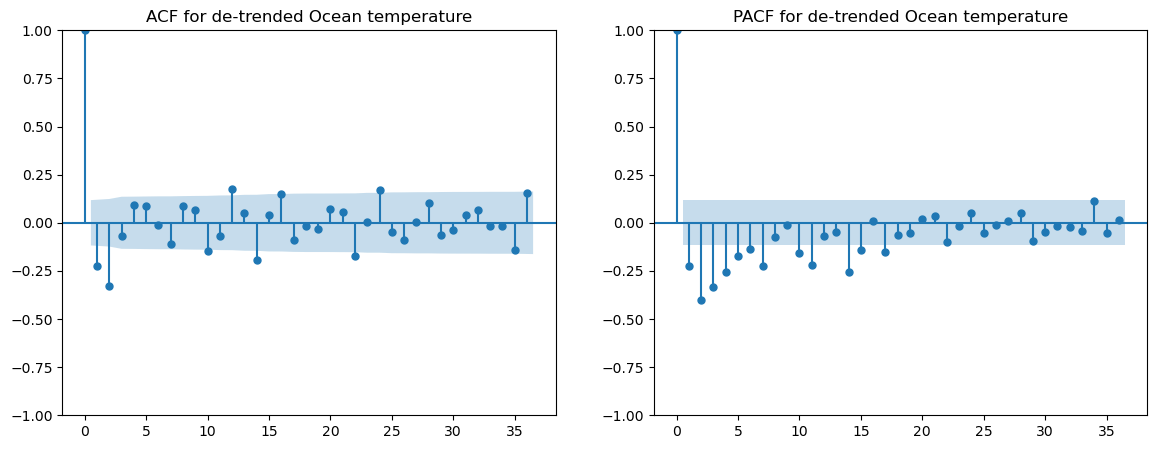

In [12]:
fig, ax= plt.subplots(1, 2, figsize = (14,5))
acf_plot = plot_acf(detrended_ocean_temp, lags = nlags, ax= ax[0])
ax[0].set_title("ACF for de-trended Ocean temperature")

acf_plot = plot_pacf(detrended_ocean_temp, lags = nlags, ax= ax[1])
ax[1].set_title("PACF for de-trended Ocean temperature");

## Augmented Dickey Fuller test

In [13]:
ADF_test_summary( pd.DataFrame(detrended_ocean_temp).dropna().rename(columns={ 0: "Events"}))

                                                    Events                                                    
Specification               Coeff          Statistic     P-value      Lags      1%          5%        10%
--------------------------------------------------------------------------------------------------------------
Constant and Trend         -11.968         -9.590        0.000         14    -3.994      -3.427     -3.137
	Constant             0.014          0.138        0.890
	Trend               -0.000         -0.320        0.749
Constant Only              -11.957         -9.602        0.000         14    -3.456      -2.873     -2.573
	Constant            -0.014         -0.279        0.780
No Constant                -11.948         -9.616        0.000         14    -2.574      -1.942     -1.616


## Seasonality analysis

In [14]:
#Obtain the month 
detrended_ocean_temp= detrended_ocean_temp.reset_index().rename(columns = {0 : "Ocean_temperature"})
detrended_ocean_temp["Quarter"] = detrended_ocean_temp["Date"].dt.quarter
detrended_ocean_temp = detrended_ocean_temp.set_index("Date")

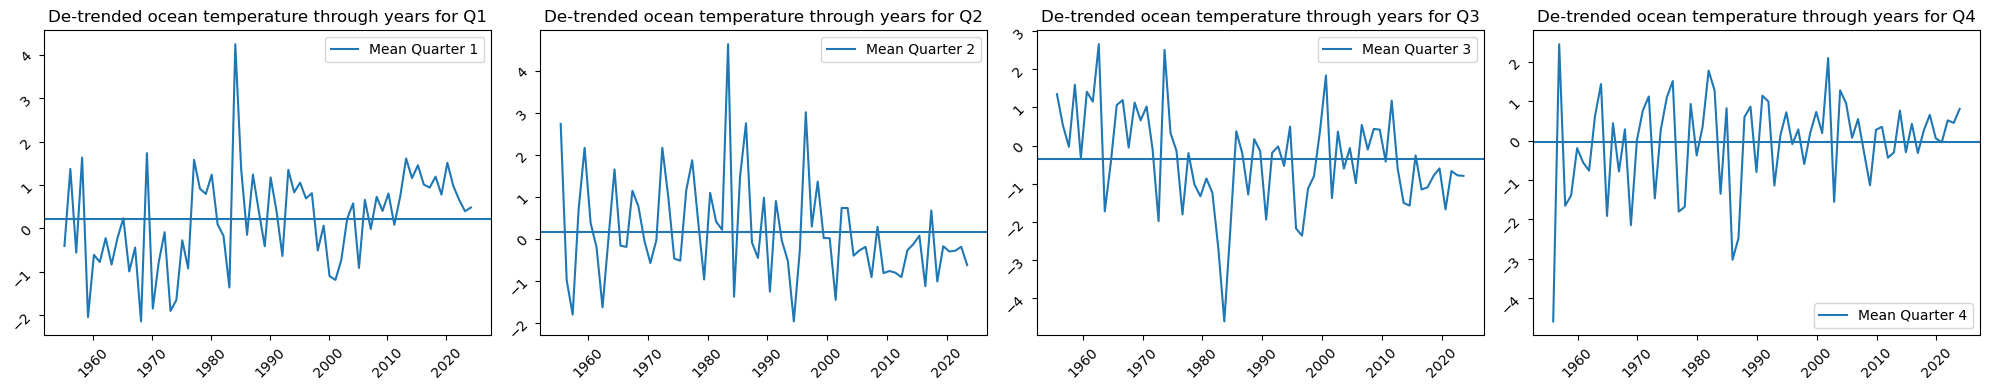

In [15]:
figure, axis = plt.subplots(1, 4, figsize=(20, 4)) 

for x in [1,2,3,4]:
    axis[x-1].plot(detrended_ocean_temp.query('Quarter == @x')["Ocean_temperature"]  )
    axis[x-1].tick_params(labelrotation=45)
    axis[x-1].axhline(y = detrended_ocean_temp.query('Quarter == @x')["Ocean_temperature"].mean(), label = f"Mean Quarter {x}")
    axis[x-1].set_title( "De-trended ocean temperature through years for Q" + str(x) )
    axis[x-1].legend()

plt.legend()
plt.tight_layout()

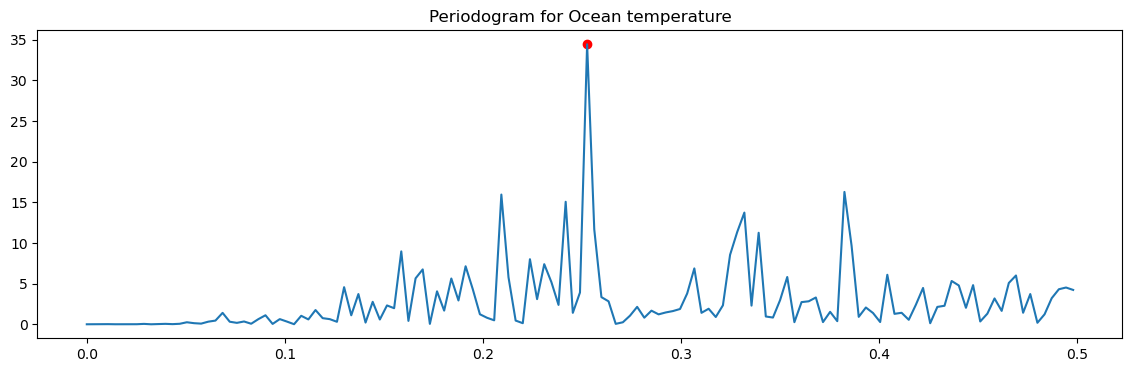

In [16]:
#Periodogram
f, Pxx = scipy.signal.periodogram(detrended_ocean_temp["Ocean_temperature"])
max_power_index = np.argmax(Pxx)
dominant_frequency = f[max_power_index]
period_length = int(1 / dominant_frequency)

fig, ax = plt.subplots(figsize=(14, 4))
ax.plot(f, Pxx, label='Periodogram')
ax.scatter(f[max_power_index], Pxx[max_power_index], color='red', label=f'Dominant Frequency: {dominant_frequency:.2f} Hz')
plt.title("Periodogram for Ocean temperature");

# Co2 emissions

## Seasonal-trend decomposition 

In [17]:
stl_co2 = STL(time_series["co2"].dropna())
result_co2 = stl_co2.fit()

In [18]:
trend_co2, seasonal_co2, resid_co2 = result_co2.trend, result_co2.seasonal,  result_co2.resid

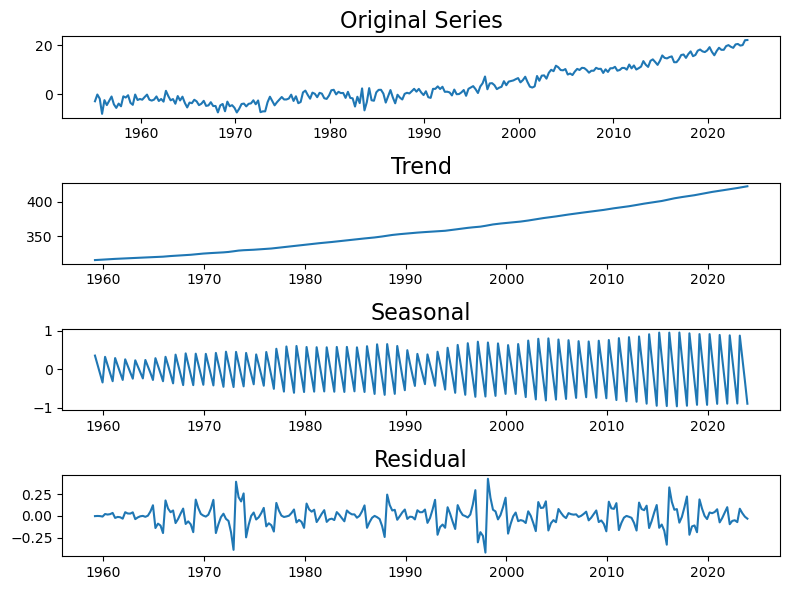

In [19]:
plt.figure(figsize=(8,6))

plt.subplot(4,1,1)
plt.plot(time_series["Temp"])
plt.title('Original Series', fontsize=16)

plt.subplot(4,1,2)
plt.plot(trend_co2)
plt.title('Trend', fontsize=16)

plt.subplot(4,1,3)
plt.plot(seasonal_co2)
plt.title('Seasonal', fontsize=16)

plt.subplot(4,1,4)
plt.plot(resid_co2)
plt.title('Residual', fontsize=16)

plt.tight_layout( )

## Remove trend

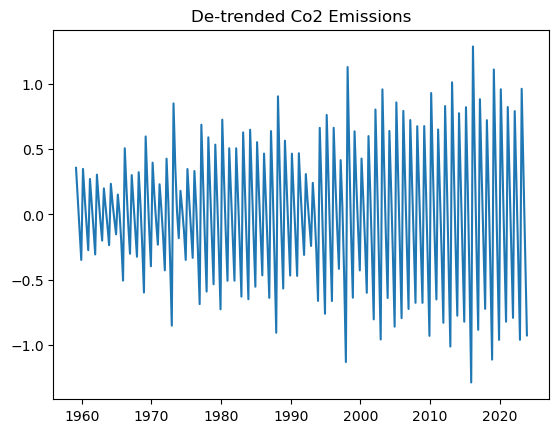

In [20]:
#Obtain de-trended
detrended_co2 = time_series["co2"] - trend_co2

plt.plot(detrended_co2)
plt.title("De-trended Co2 Emissions");

## ACF and PACF

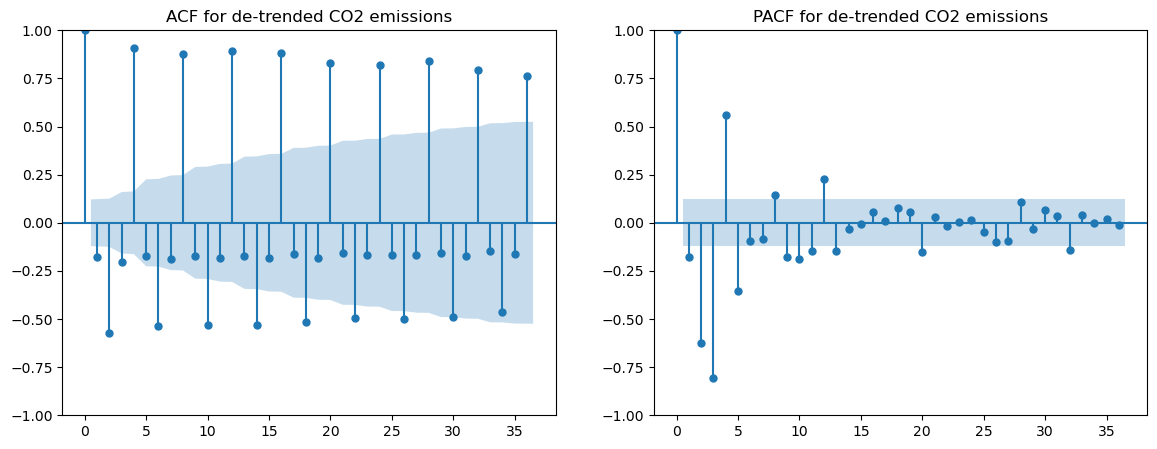

In [21]:
fig, ax= plt.subplots(1, 2, figsize = (14,5))
acf_plot = plot_acf(detrended_co2.dropna(), lags = nlags, ax=ax[0])
ax[0].set_title("ACF for de-trended CO2 emissions")

pacf_plot = plot_pacf(detrended_co2.dropna(), lags = nlags, ax = ax[1])
ax[1].set_title("PACF for de-trended CO2 emissions");

## Augmented Dickey Fuller test

In [22]:
ADF_test_summary( pd.DataFrame(detrended_co2).dropna().rename(columns={ 0: "Events"}))

                                                    Events                                                    
Specification               Coeff          Statistic     P-value      Lags      1%          5%        10%
--------------------------------------------------------------------------------------------------------------
Constant and Trend          -4.723         -6.000        0.000         15    -3.996      -3.429     -3.138
	Constant            -0.015         -0.918        0.360
	Trend                0.000          0.410        0.683
Constant Only               -4.714         -6.002        0.000         15    -3.457      -2.873     -2.573
	Constant            -0.009         -1.124        0.262
No Constant                 -4.569         -5.894        0.000         15    -2.575      -1.942     -1.616


## Seasonality analysis

In [23]:
#Obtain the month 
detrended_co2= detrended_co2.reset_index().rename(columns = {0 : "Co2"})
detrended_co2["Quarter"] = detrended_co2["Date"].dt.quarter
detrended_co2 = detrended_co2.set_index("Date")

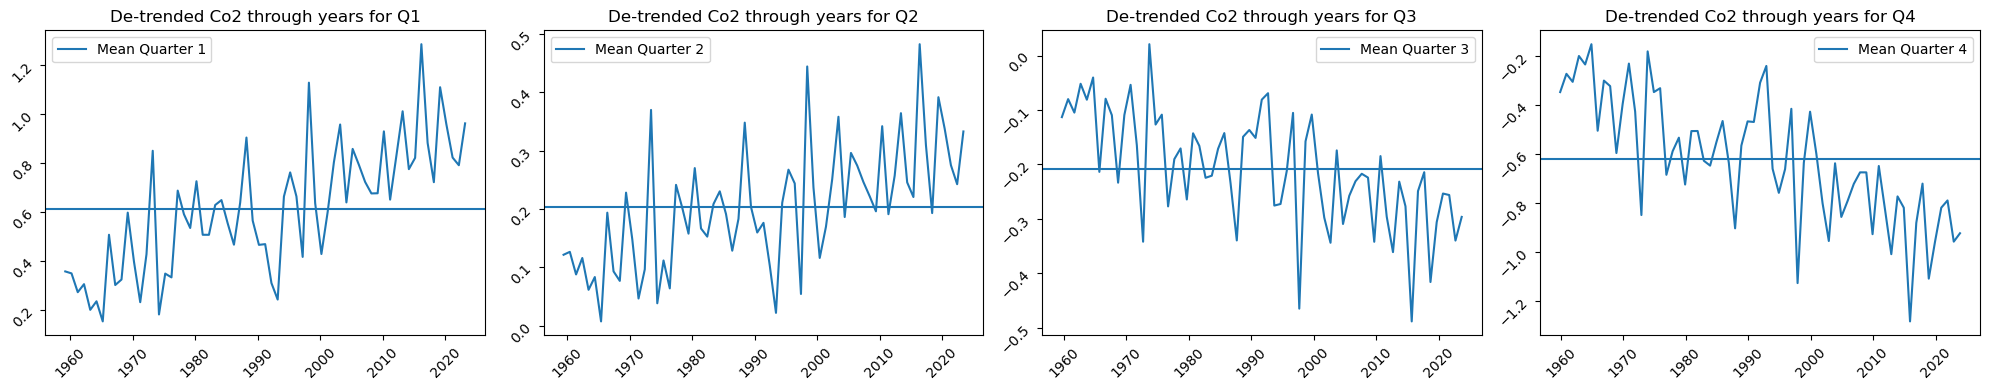

In [24]:
figure, axis = plt.subplots(1, 4, figsize=(20, 4)) 

for x in [1,2,3,4]:
    axis[x-1].plot(detrended_co2.query('Quarter == @x')["Co2"]  )
    axis[x-1].tick_params(labelrotation=45)
    axis[x-1].axhline(y = detrended_co2.query('Quarter == @x')["Co2"].mean(), label = f"Mean Quarter {x}")
    axis[x-1].set_title( "De-trended Co2 through years for Q" + str(x) )
    axis[x-1].legend()

plt.legend()
plt.tight_layout()

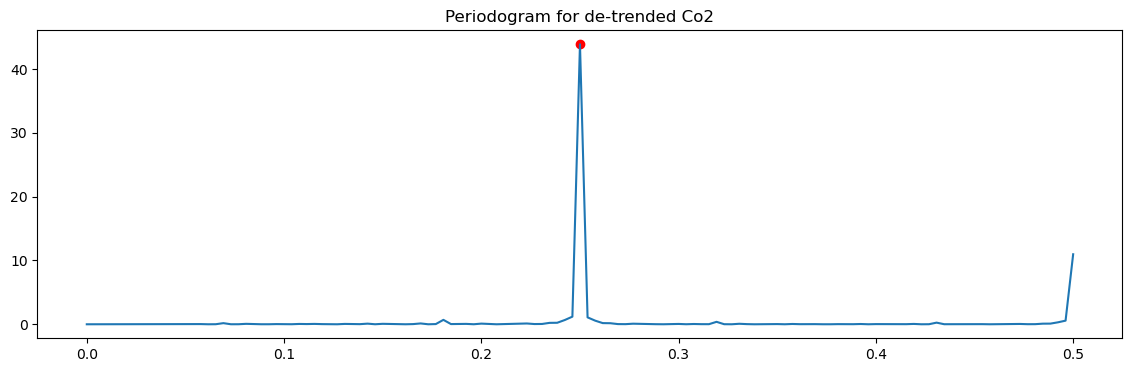

In [25]:
#Periodogram
f, Pxx = scipy.signal.periodogram(detrended_co2["Co2"].dropna())
max_power_index = np.argmax(Pxx)
dominant_frequency = f[max_power_index]
period_length = int(1 / dominant_frequency)

fig, ax = plt.subplots(figsize=(14, 4))
ax.plot(f, Pxx, label='Periodogram')
ax.scatter(f[max_power_index], Pxx[max_power_index], color='red', label=f'Dominant Frequency: {dominant_frequency:.2f} Hz')
plt.title("Periodogram for de-trended Co2");

# World precipitation

## Seasonal-trend decomposition 

In [26]:
stl_precip = STL(time_series["precip"].dropna())
result_precip = stl_precip.fit()

In [27]:
trend_precip, seasonal_precip, resid_precip = result_precip.trend, result_precip.seasonal,  result_precip.resid

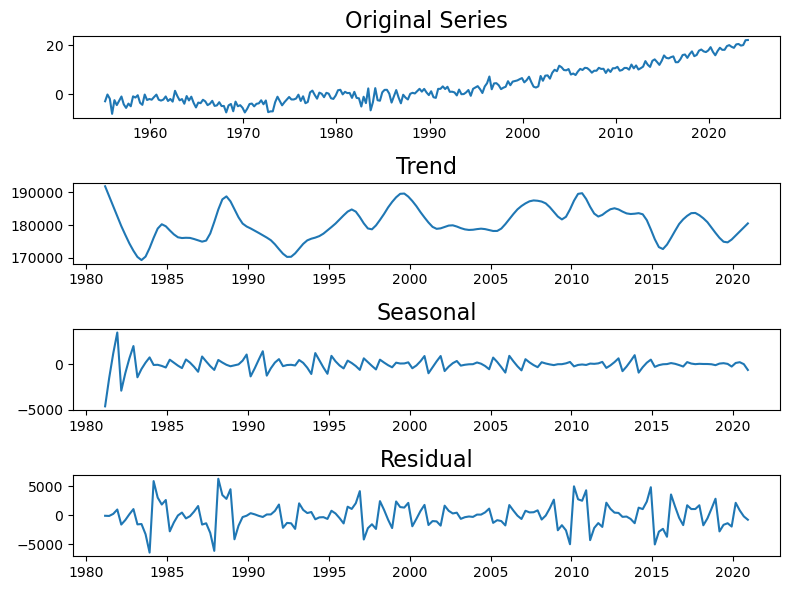

In [28]:
plt.figure(figsize=(8,6))

plt.subplot(4,1,1)
plt.plot(time_series["Temp"])
plt.title('Original Series', fontsize=16)

plt.subplot(4,1,2)
plt.plot(trend_precip)
plt.title('Trend', fontsize=16)

plt.subplot(4,1,3)
plt.plot(seasonal_precip)
plt.title('Seasonal', fontsize=16)

plt.subplot(4,1,4)
plt.plot(resid_precip)
plt.title('Residual', fontsize=16)

plt.tight_layout( )

## Remove trend

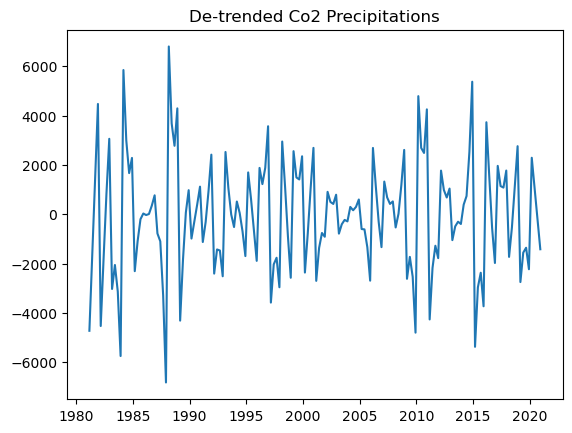

In [29]:
#Obtain de-trended
detrended_precip = time_series["precip"] - trend_precip

plt.plot(detrended_precip)
plt.title("De-trended Co2 Precipitations");

## ACF and PACF

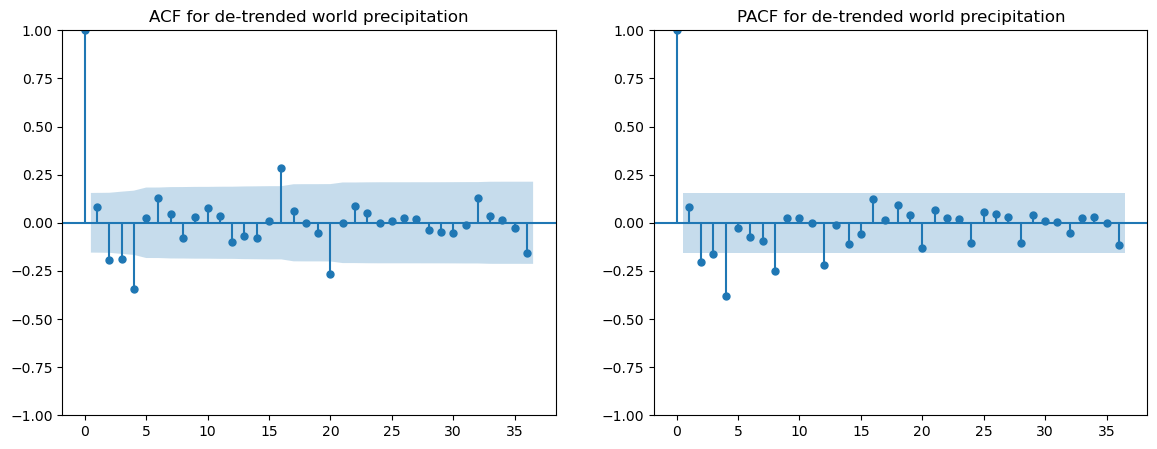

In [30]:
fig, ax= plt.subplots(1, 2, figsize = (14,5))
acf_plot = plot_acf(detrended_precip.dropna(), lags = nlags, ax = ax[0])
ax[0].set_title("ACF for de-trended world precipitation");

pacf_plot = plot_pacf(detrended_precip.dropna(), lags = nlags, ax = ax[1])
ax[1].set_title("PACF for de-trended world precipitation");

## Augmented Dickey Fuller test

In [31]:
ADF_test_summary(time_series["precip"].dropna())

                                                    precip                                                    
Specification               Coeff          Statistic     P-value      Lags      1%          5%        10%
--------------------------------------------------------------------------------------------------------------
Constant and Trend          -0.214         -3.490        0.040          4    -4.018      -3.439     -3.144
	Constant         38102.698          3.497        0.001
	Trend                5.664          0.912        0.363
Constant Only               -0.195         -3.382        0.012          4    -3.473      -2.880     -2.577
	Constant         35179.495          3.380        0.001
No Constant                 -0.000         -0.109        0.647          4    -2.580      -1.943     -1.615


## Seasonality analysis

In [32]:
#Obtain the month 
detrended_precip= detrended_precip.reset_index().rename(columns = {0 : "precip"})
detrended_precip["Quarter"] = detrended_precip["Date"].dt.quarter
detrended_precip = detrended_precip.set_index("Date")

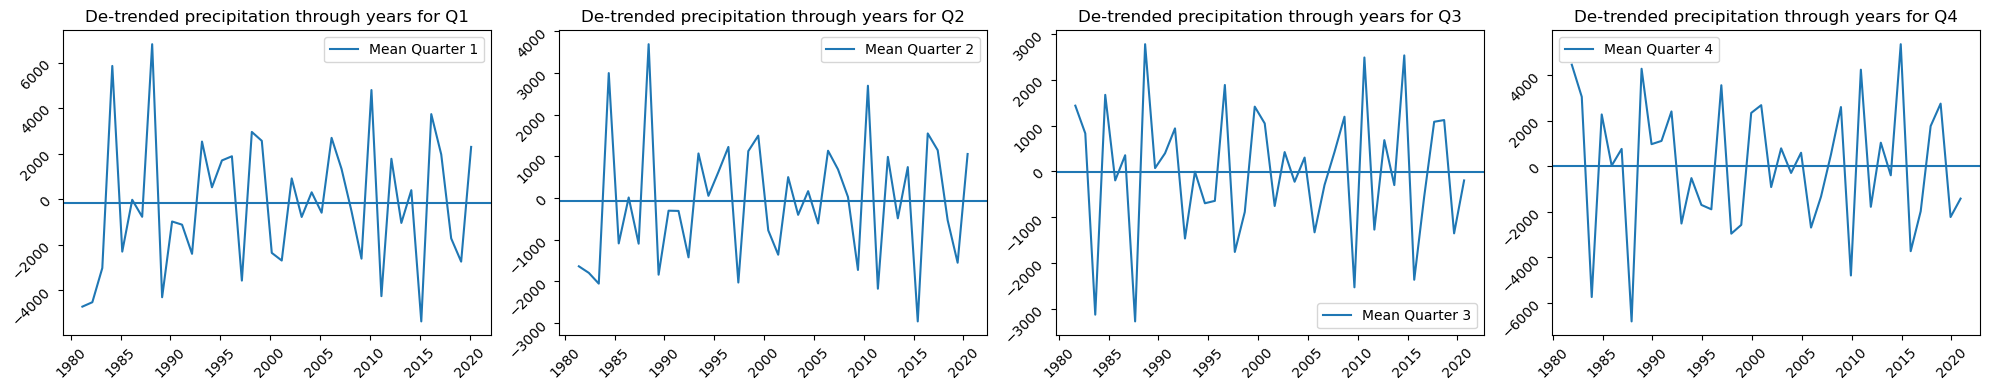

In [33]:
figure, axis = plt.subplots(1, 4, figsize=(20, 4)) 

for x in [1,2,3,4]:
    axis[x-1].plot(detrended_precip.query('Quarter == @x')["precip"]  )
    axis[x-1].tick_params(labelrotation=45)
    axis[x-1].axhline(y = detrended_precip.query('Quarter == @x')["precip"].mean(), label = f"Mean Quarter {x}")
    axis[x-1].set_title( "De-trended precipitation through years for Q" + str(x) )
    axis[x-1].legend()

plt.legend()
plt.tight_layout()

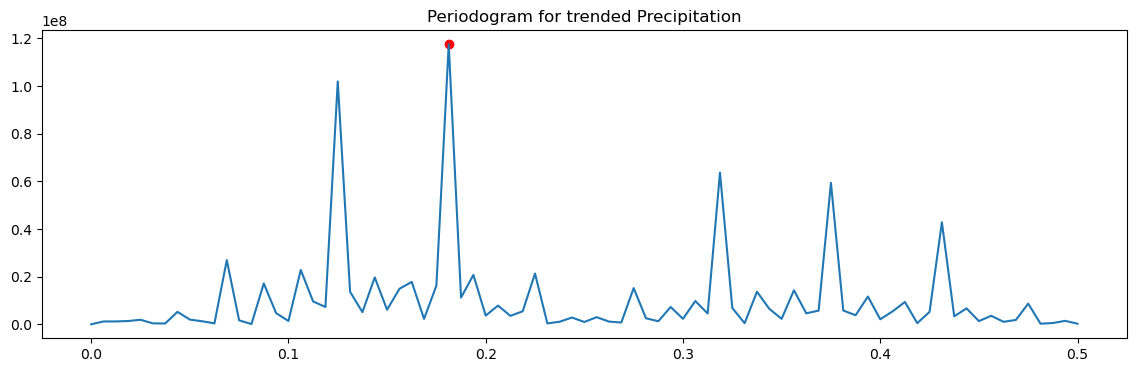

In [34]:
#Periodogram
f, Pxx = scipy.signal.periodogram(detrended_precip["precip"].dropna())
max_power_index = np.argmax(Pxx)
dominant_frequency = f[max_power_index]
period_length = int(1 / dominant_frequency)

fig, ax = plt.subplots(figsize=(14, 4))
ax.plot(f, Pxx, label='Periodogram')
ax.scatter(f[max_power_index], Pxx[max_power_index], color='red', label=f'Dominant Frequency: {dominant_frequency:.2f} Hz')
plt.title("Periodogram for trended Precipitation");

# Total disasters reported around the world

## Seasonal-trend decomposition 

In [35]:
stl_events = STL( total_events_world.dropna().astype("int"), period = 2)
result_events = stl_events.fit()

In [36]:
trend_events, seasonal_events, resid_events = result_events.trend, result_events.seasonal,  result_events.resid

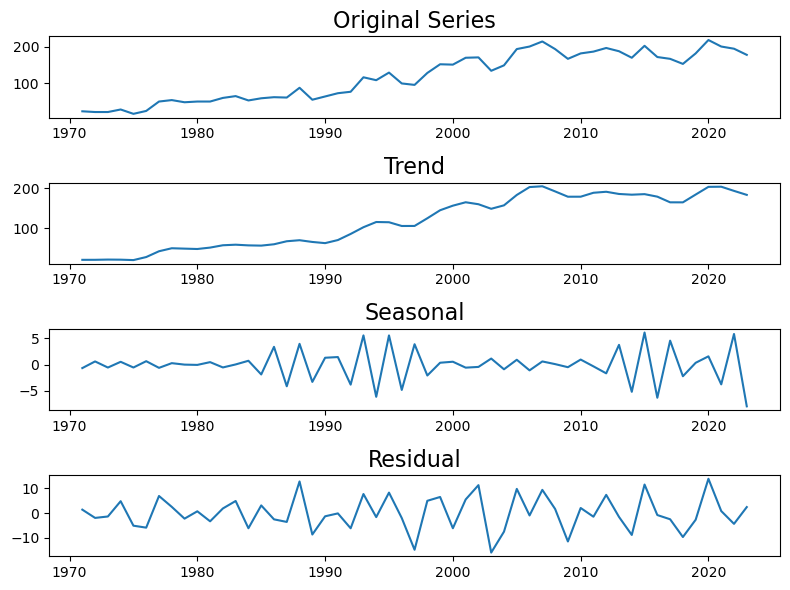

In [37]:
plt.figure(figsize=(8,6))

plt.subplot(4,1,1)
plt.plot(total_events_world)
plt.title('Original Series', fontsize=16)

plt.subplot(4,1,2)
plt.plot(trend_events)
plt.title('Trend', fontsize=16)

plt.subplot(4,1,3)
plt.plot(seasonal_events)
plt.title('Seasonal', fontsize=16)

plt.subplot(4,1,4)
plt.plot(resid_events)
plt.title('Residual', fontsize=16)

plt.tight_layout( )

## Remove trend

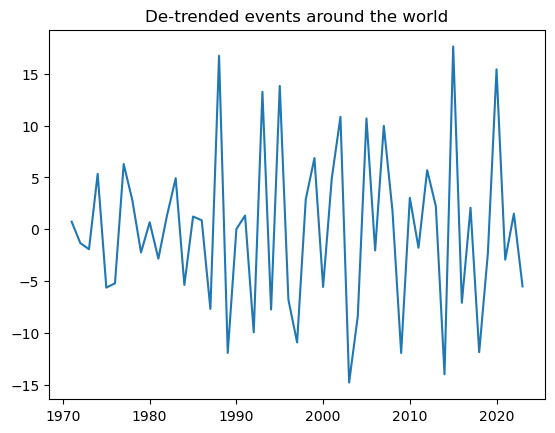

In [38]:
#Obtain de-trended
detrended_events = total_events_world.dropna().astype("float")["Total_events"] - trend_events.astype("float")

plt.plot(detrended_events)
plt.title("De-trended events around the world");

## ACF and PACF

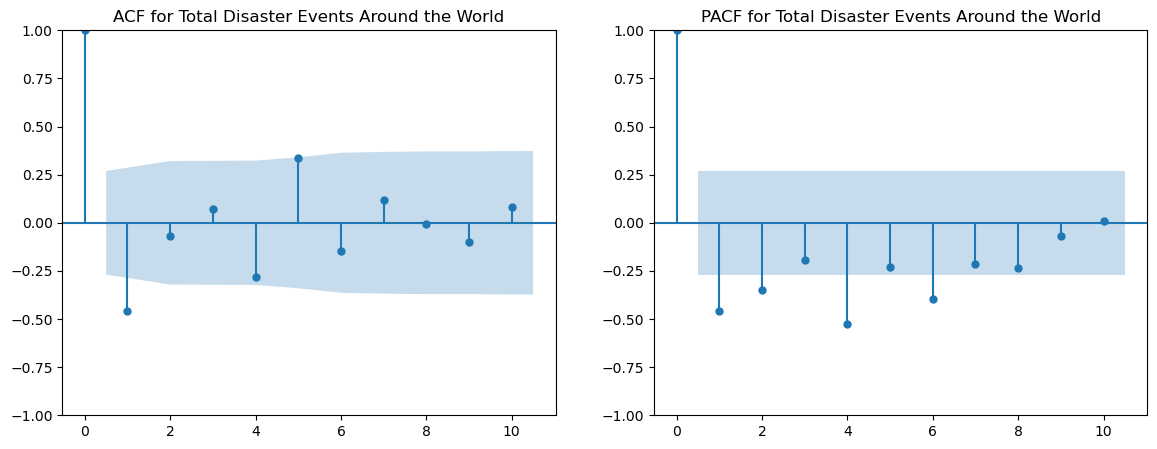

In [39]:
fig, ax= plt.subplots(1, 2, figsize = (14,5))
acf_plot = plot_acf(detrended_events.dropna(), lags = 10, ax = ax[0])
ax[0].set_title("ACF for Total Disaster Events Around the World");

pacf_plot = plot_pacf(detrended_events.dropna(), lags = 10, ax = ax[1])
ax[1].set_title("PACF for Total Disaster Events Around the World");

## Augmented Dickey Fuller test

In [40]:
ADF_test_summary(pd.DataFrame(detrended_events).dropna().rename(columns={ 0: "Events"}) )

                                                    Events                                                    
Specification               Coeff          Statistic     P-value      Lags      1%          5%        10%
--------------------------------------------------------------------------------------------------------------
Constant and Trend          -6.578         -7.041        0.000          5    -4.166      -3.508     -3.184
	Constant             0.044          0.027        0.978
	Trend               -0.002         -0.033        0.974
Constant Only               -6.579         -7.134        0.000          5    -3.578      -2.925     -2.601
	Constant            -0.002         -0.002        0.998
No Constant                 -6.579         -7.231        0.000          5    -2.615      -1.948     -1.612


# Total floods reported around the world

## Seasonal-trend decomposition 

In [41]:
stl_floods = STL( total_floods_world.dropna(), period = 2)
result_floods = stl_floods.fit()

In [42]:
trend_floods, seasonal_floods, resid_floods = result_floods.trend, result_floods.seasonal,  result_floods.resid

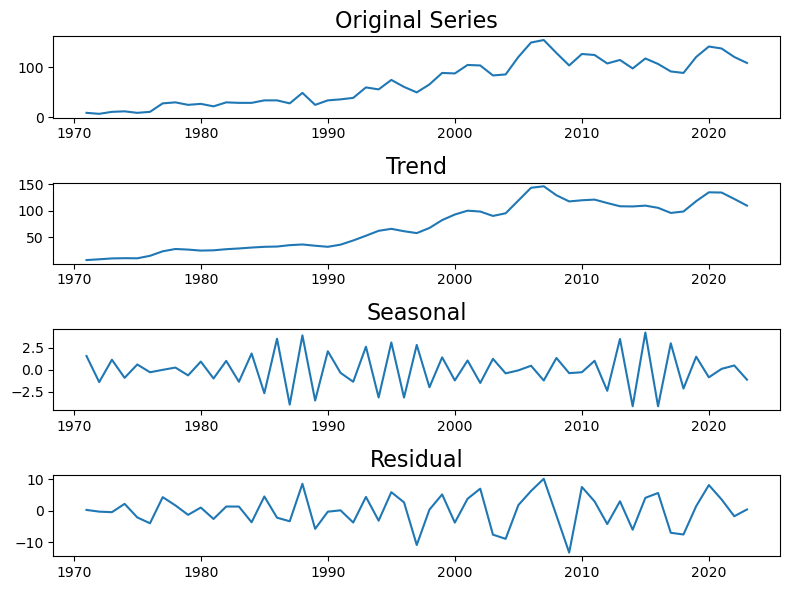

In [43]:
plt.figure(figsize=(8,6))

plt.subplot(4,1,1)
plt.plot(total_floods_world)
plt.title('Original Series', fontsize=16)

plt.subplot(4,1,2)
plt.plot(trend_floods)
plt.title('Trend', fontsize=16)

plt.subplot(4,1,3)
plt.plot(seasonal_floods)
plt.title('Seasonal', fontsize=16)

plt.subplot(4,1,4)
plt.plot(resid_floods)
plt.title('Residual', fontsize=16)

plt.tight_layout( )

## Remove trend

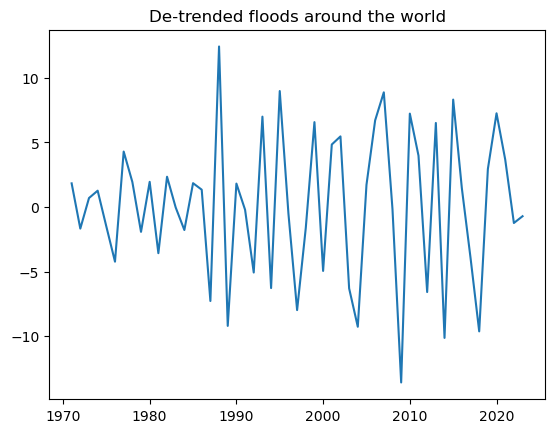

In [44]:
#Obtain de-trended
detrended_floods = total_floods_world.dropna().astype("float")["Flood"] - trend_floods.astype("float")

plt.plot(detrended_floods)
plt.title("De-trended floods around the world");

## ACF and PACF

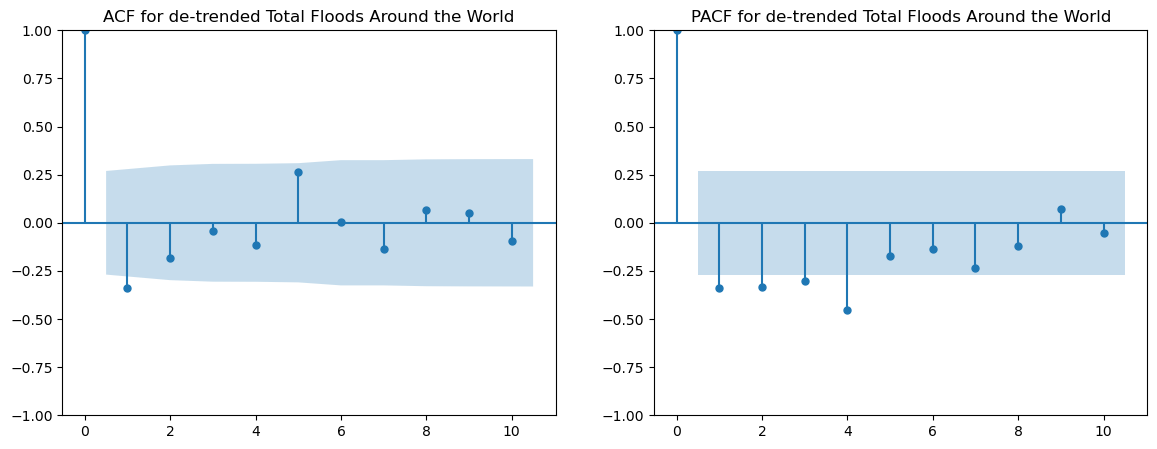

In [45]:
fig, ax= plt.subplots(1, 2, figsize = (14,5))
acf_plot = plot_acf(detrended_floods.dropna(), lags = 10, ax = ax[0])
ax[0].set_title("ACF for de-trended Total Floods Around the World");

pacf_plot = plot_pacf(detrended_floods.dropna(), lags = 10, ax = ax[1])
ax[1].set_title("PACF for de-trended Total Floods Around the World");

## Augmented Dickey Fuller test

In [46]:
ADF_test_summary(pd.DataFrame(detrended_floods).dropna().rename(columns={ 0: "Events"}))

                                                    Events                                                    
Specification               Coeff          Statistic     P-value      Lags      1%          5%        10%
--------------------------------------------------------------------------------------------------------------
Constant and Trend          -3.455         -7.820        0.000          3    -4.157      -3.504     -3.182
	Constant            -0.503         -0.369        0.714
	Trend                0.025          0.533        0.597
Constant Only               -3.445         -7.869        0.000          3    -3.571      -2.923     -2.599
	Constant             0.130          0.195        0.847
No Constant                 -3.443         -7.952        0.000          3    -2.613      -1.948     -1.612


# Total damages reported around the world

## Seasonal-trend decomposition 

In [47]:
stl_damages = STL( total_damages_world.dropna(), period = 2)
result_damages = stl_damages.fit()

In [48]:
trend_damages, seasonal_damages, resid_damages = result_damages.trend, result_damages.seasonal,  result_damages.resid

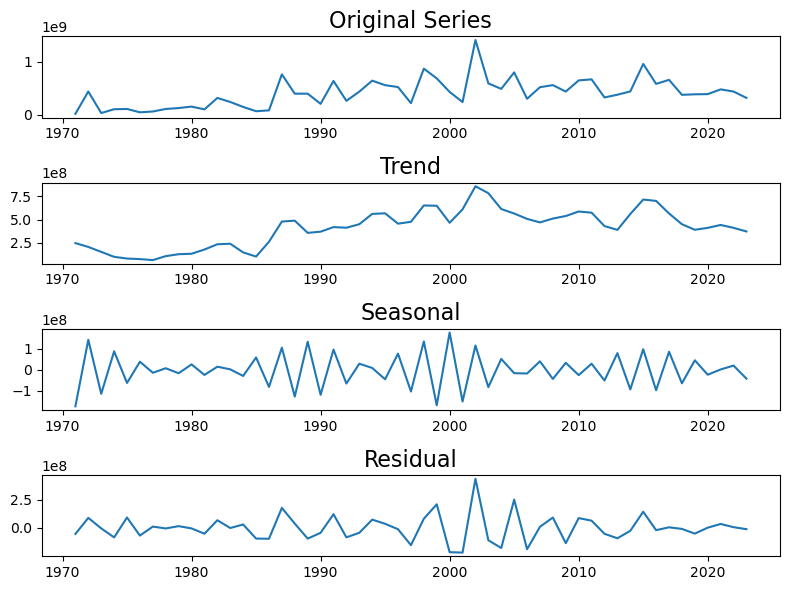

In [49]:
plt.figure(figsize=(8,6))

plt.subplot(4,1,1)
plt.plot(total_damages_world)
plt.title('Original Series', fontsize=16)

plt.subplot(4,1,2)
plt.plot(trend_damages)
plt.title('Trend', fontsize=16)

plt.subplot(4,1,3)
plt.plot(seasonal_damages)
plt.title('Seasonal', fontsize=16)

plt.subplot(4,1,4)
plt.plot(resid_damages)
plt.title('Residual', fontsize=16)

plt.tight_layout( )

## Remove trend

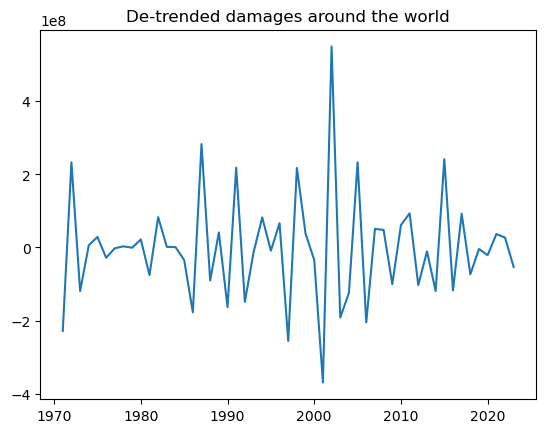

In [50]:
#Obtain de-trended
detrended_damages = total_damages_world.dropna().astype("float")["Total_damages"] - trend_damages.astype("float")

plt.plot(detrended_damages)
plt.title("De-trended damages around the world");

## ACF and PACF

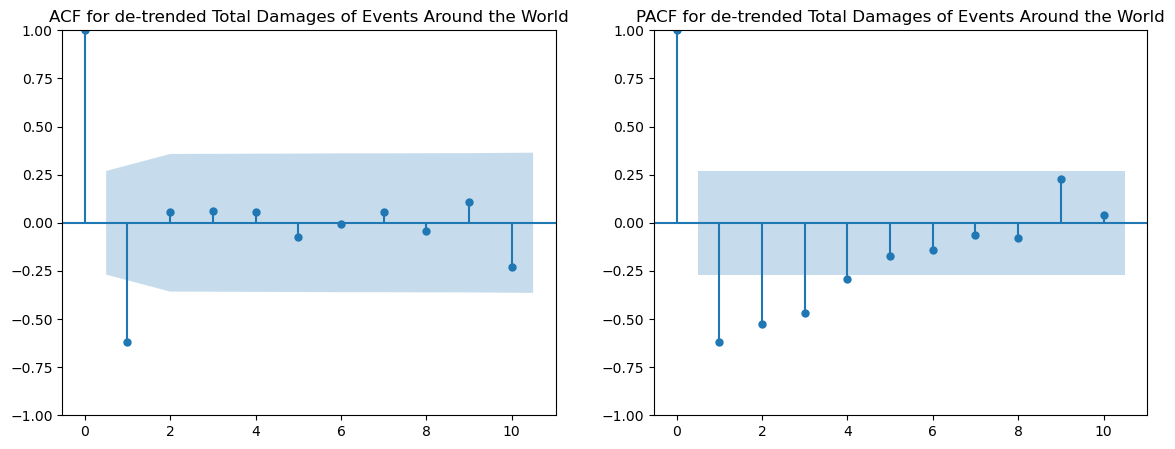

In [51]:
fig, ax= plt.subplots(1, 2, figsize = (14,5))
acf_plot = plot_acf(detrended_damages.dropna(), lags = 10, ax = ax[0])
ax[0].set_title("ACF for de-trended Total Damages of Events Around the World");

pacf_plot = plot_pacf(detrended_damages.dropna(), lags = 10, ax = ax[1])
ax[1].set_title("PACF for de-trended Total Damages of Events Around the World");

## Augmented Dickey Fuller test

In [52]:
ADF_test_summary(pd.DataFrame(detrended_damages).dropna().rename(columns={ 0: "Events"}))

                                                    Events                                                    
Specification               Coeff          Statistic     P-value      Lags      1%          5%        10%
--------------------------------------------------------------------------------------------------------------
Constant and Trend         -16.048         -6.313        0.000          7    -4.175      -3.513     -3.187
	Constant     -17848978.817         -0.778        0.442
	Trend           902458.586          1.028        0.311
Constant Only              -15.500         -6.231        0.000          7    -3.585      -2.928     -2.602
	Constant       2793096.678          0.251        0.803
No Constant                -15.474         -6.307        0.000          7    -2.617      -1.948     -1.612


# Cointegration analysis: Engle-Granger Cointegration Test

### Co2 and Ocean Temperature 

In [53]:
y = time_series[["co2","Temp"]].dropna()["co2"].values
x = time_series[["co2","Temp"]].dropna()["Temp"].values
t_statistic, p_val, critical_p_val = coint(y,x)
print(f' t statistic: {np.round(t_statistic, 2)} \n p value: {np.round(p_val,2)} \n critical p values [1%, 5%, 10%]critical_p_val: {critical_p_val}')

 t statistic: -3.1 
 p value: 0.09 
 critical p values [1%, 5%, 10%]critical_p_val: [-3.93922513 -3.35982283 -3.06086584]


In this case, we do not observe cointegration for 5% and 1% significance levels, but we do for 10%

### Co2 and Precipitation

In [54]:
y = time_series[["co2","precip"]].dropna()["co2"].values
x = time_series[["co2","precip"]].dropna()["precip"].values
t_statistic, p_val, critical_p_val = coint(y,x)
print(f' t statistic: {np.round(t_statistic, 2)} \n p value: {np.round(p_val,2)} \n critical p values [1%, 5%, 10%]critical_p_val: {critical_p_val}')

 t statistic: -0.57 
 p value: 0.96 
 critical p values [1%, 5%, 10%]critical_p_val: [-3.96664605 -3.37482819 -3.0712318 ]


### Precipitation and Ocean Temperature 

In [55]:
y = time_series[["precip","Temp"]].dropna()["precip"].values
x = time_series[["precip","Temp"]].dropna()["Temp"].values
t_statistic, p_val, critical_p_val = coint(y,x)
print(f' t statistic: {np.round(t_statistic, 2)} \n p value: {np.round(p_val,2)} \n critical p values [1%, 5%, 10%]critical_p_val: {critical_p_val}')

 t statistic: -2.3 
 p value: 0.37 
 critical p values [1%, 5%, 10%]critical_p_val: [-3.96664605 -3.37482819 -3.0712318 ]
